<a href="https://colab.research.google.com/github/sohv/iisc-assignment/blob/main/q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install dependencies

In [ ]:
%pip install torch opencv-python pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 72.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 58.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 132.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install git+https://github.com/facebookresearch/segment-anything-2.git

  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-ttgbxclq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-ttgbxclq
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-cp312-cp312-linux_x86_64.whl size=486185 sha256=311d13316a0eb8d69e4941880d7bf503d87823801a7a46fb5cdee687cf0acd30
  Stored in directory: /tmp/pip-ephem-wheel-cache-y8a0i52t/wheels/b0/5b/a1/c16dafb8c3c0046f1158e7fa7570559a72085df5beab759ba0
  DEPRECATION: Building 'antlr4-python3-runtime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future ver

In [ ]:
%pip install groundingdino-py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 71.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 210.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 168.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.0/802.0 kB 120.2 MB/s  0:00:00
  DEPRECATION: Building 'groundingdino-py' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'groundingdino-py'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for groundingdino-py: filename=groundingdino_py-0.4.0-py2.py3-none-any.whl size=88812 sha256=8ccf94801e82a35d0f37a68b135212f0955805ccd4b6de6cdd41c310c395e7e9
  St

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import argparse
from pathlib import Path
import os
import urllib.request

In [ ]:
# Download the checkpoints for the model
def download_checkpoints():
    os.makedirs("checkpoints", exist_ok=True)

    checkpoints = {
        "sam2_hiera_large.pt": "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt",
        "groundingdino_swint_ogc.pth": "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth",
        "GroundingDINO_SwinT_OGC.py": "https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/main/groundingdino/config/GroundingDINO_SwinT_OGC.py"
    }

    for filename, url in checkpoints.items():
        filepath = f"checkpoints/{filename}"
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(url, filepath)
            print(f" Downloaded {filename}")
        else:
            print(f" {filename} already exists")

    print(" All checkpoints ready!")

### Image Segmentation

In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from groundingdino.util.inference import load_model
from groundingdino.util.inference import load_image, predict

/venv/main/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
def setup_models(device="cuda"):
    print("Loading models...")

    # Initialize SAM 2
    sam2_checkpoint = "checkpoints/sam2_hiera_large.pt"
    model_cfg = "sam2_hiera_l.yaml"

    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
    sam2_predictor = SAM2ImagePredictor(sam2_model)

    # Initialize GroundingDINO
    grounding_dino_model = load_model(
        "checkpoints/GroundingDINO_SwinT_OGC.py",
        "checkpoints/groundingdino_swint_ogc.pth",
        device=device
    )

    print(" Models loaded successfully")
    return sam2_predictor, grounding_dino_model

In [ ]:
def detect_objects_with_text(grounding_model, image_path, text_prompt,
                             box_threshold=0.35, text_threshold=0.25, device="cuda"):
    # load image
    image_source, image = load_image(image_path)

    # predict
    boxes, logits, phrases = predict(
        model=grounding_model,
        image=image,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold,
        device=device
    )

    # convert boxes to image coordinates
    h, w, _ = image_source.shape
    boxes = boxes * torch.tensor([w, h, w, h], device=boxes.device)

    # convert from cxcywh to xyxy format
    boxes_xyxy = torch.zeros_like(boxes)
    boxes_xyxy[:, 0] = boxes[:, 0] - boxes[:, 2] / 2
    boxes_xyxy[:, 1] = boxes[:, 1] - boxes[:, 3] / 2
    boxes_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2] / 2
    boxes_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3] / 2

    return boxes_xyxy.cpu().numpy(), logits.cpu().numpy(), phrases

In [ ]:
def segment_with_sam2(sam2_predictor, image, boxes):
    # use SAM 2 to generate precise masks from bounding boxes.
    sam2_predictor.set_image(image)
    masks, scores, _ = sam2_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=boxes,
        multimask_output=False,
    )
    return masks, scores

### Visualizing segmentation

In [ ]:
def visualize_segmentation(image, boxes, masks, phrases, logits, output_path):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # detected boxes
    axes[1].imshow(image)
    for box, phrase, score in zip(boxes, phrases, logits):
        x0, y0, x1, y1 = box
        w, h = x1 - x0, y1 - y0
        axes[1].add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green',
                                        facecolor='none', lw=2))
        axes[1].text(x0, y0 - 5, f"{phrase} ({score:.2f})", color='green',
                    fontsize=10, bbox=dict(facecolor='white', alpha=0.7,
                                          edgecolor='none', pad=1))
    axes[1].set_title('Detection Results')
    axes[1].axis('off')

    # Segmentation masks
    axes[2].imshow(image)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(masks)))
    for i, (mask, box, phrase) in enumerate(zip(masks, boxes, phrases)):
        # handle mask dimensions properly
        color = colors[i][:3]
        color_with_alpha = np.array([*color, 0.5])

        # get the actual mask (remove batch dimension if present)
        if mask.ndim == 3:
            mask_2d = mask[0]  # Shape: (H, W)
        else:
            mask_2d = mask  # Already (H, W)

        h, w = mask_2d.shape
        mask_image = mask_2d.reshape(h, w, 1) * color_with_alpha.reshape(1, 1, -1)
        axes[2].imshow(mask_image)

        # show box
        x0, y0, x1, y1 = box
        box_w, box_h = x1 - x0, y1 - y0
        axes[2].add_patch(plt.Rectangle((x0, y0), box_w, box_h, edgecolor=color,
                                        facecolor='none', lw=2))
        axes[2].text(x0, y0 - 5, phrase, color=color, fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

    axes[2].set_title('SAM 2 Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f" Results saved to {output_path}")
    plt.close()

In [ ]:
def segment_image(image_path, text_prompt, output_path="segmentation_result.png",
                 device="cuda"):
    # load models
    sam2_predictor, grounding_model = setup_models(device)

    # detect objects
    print(f"Detecting '{text_prompt}' in image...")
    boxes, logits, phrases = detect_objects_with_text(
        grounding_model, image_path, text_prompt, device=device
    )

    if len(boxes) == 0:
        print(f"No '{text_prompt}' detected. Try adjusting thresholds or different prompt.")
        return

    print(f"Found {len(boxes)} object(s)")

    # load image for SAM 2
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # segment with SAM 2
    print("Generating masks with SAM 2...")
    masks, scores = segment_with_sam2(sam2_predictor, image, boxes)
    print(f"Generated {len(masks)} mask(s)")

    # visualize the segmentation
    visualize_segmentation(image, boxes, masks, phrases, logits, output_path)
    print(" Image segmentation complete!")

    return masks, boxes, phrases

### Main function

In [ ]:
def main():
    # configuration

    download_checkpoints()

    IMAGE_PATH = "person.jpg"
    TEXT_PROMPT = "person"
    OUTPUT_PATH = "segmentation_result.png"
    DEVICE = "cuda"

    print(f"Using device: {DEVICE}")
    print(f"Image: {IMAGE_PATH}")
    print(f"Prompt: '{TEXT_PROMPT}'")
    print(f"Output: {OUTPUT_PATH}")

    # run segmentation
    segment_image(IMAGE_PATH, TEXT_PROMPT, OUTPUT_PATH, DEVICE)


if __name__ == "__main__":
    main()

 sam2_hiera_large.pt already exists
 groundingdino_swint_ogc.pth already exists
 GroundingDINO_SwinT_OGC.py already exists
 All checkpoints ready!
Using device: cuda
Image: person.jpg
Prompt: 'person'
Output: segmentation_result.png
Loading models...


/venv/main/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
 Models loaded successfully
Detecting 'person' in image...


/venv/main/lib/python3.12/site-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/venv/main/lib/python3.12/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/venv/main/lib/python3.12/site-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

Found 1 object(s)
Generating masks with SAM 2...
Generated 1 mask(s)
 Results saved to segmentation_result.png
 Image segmentation complete!


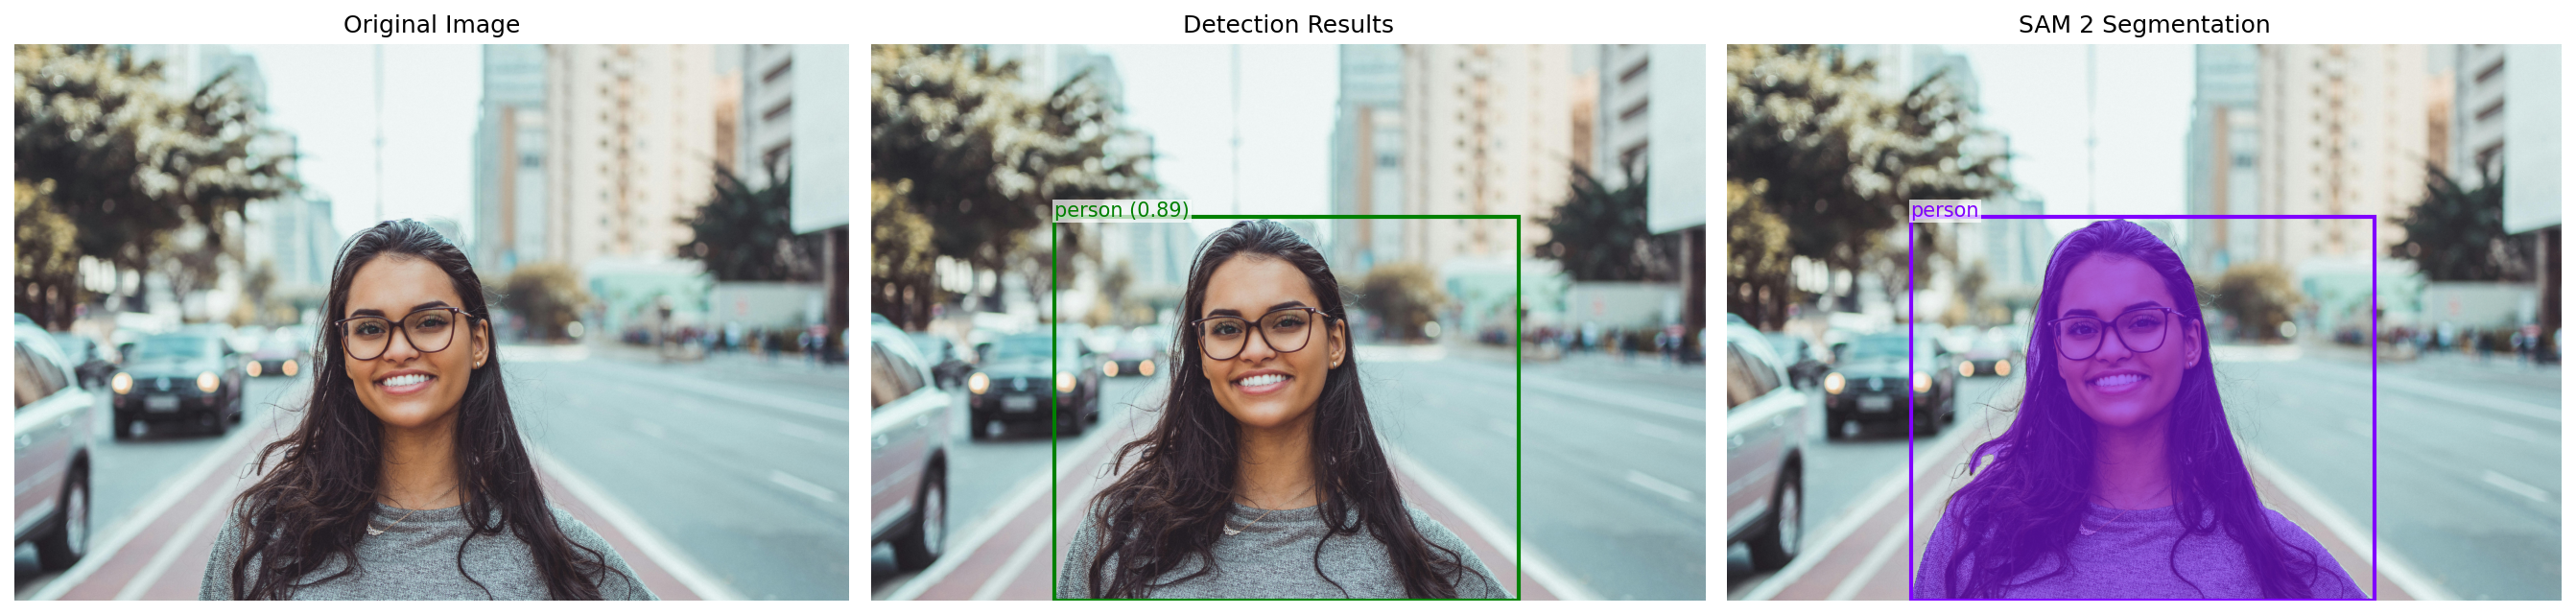

In [ ]:
# Viewing the segmented image
img = Image.open('segmentation_result.png')
img

### BONUS - Video Segmentation

In [ ]:
# Setup video models
from sam2.build_sam import build_sam2_video_predictor
from groundingdino.util.inference import load_model

In [ ]:
def setup_video_models(device="cuda"):
    print("Loading models for video...")

    # initialize SAM 2 video predictor
    sam2_checkpoint = "checkpoints/sam2_hiera_large.pt"
    model_cfg = "sam2_hiera_l.yaml"

    sam2_video_predictor = build_sam2_video_predictor(
        model_cfg, sam2_checkpoint, device=device
    )

    # initialize GroundingDINO
    grounding_dino_model = load_model(
        "checkpoints/GroundingDINO_SwinT_OGC.py",
        "checkpoints/groundingdino_swint_ogc.pth",
        device=device
    )

    print(" Video models loaded successfully")
    return sam2_video_predictor, grounding_dino_model

In [ ]:
def extract_frames(video_path, output_dir="video_frames"):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video: {frame_count} frames at {fps:.2f} FPS")

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_path = os.path.join(output_dir, f"{frame_idx:05d}.jpg")
        cv2.imwrite(frame_path, frame)
        frame_idx += 1

    cap.release()
    print(f" Extracted {frame_count} frames to {output_dir}")
    return output_dir, fps, frame_count

In [ ]:
def create_video_from_frames(frame_dir, output_path, fps):
    frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith('.jpg')])

    if not frame_files:
        print("No frames found!")
        return

    # read first frame to get dimensions
    first_frame = cv2.imread(os.path.join(frame_dir, frame_files[0]))
    height, width = first_frame.shape[:2]

    # create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame_file in frame_files:
        frame = cv2.imread(os.path.join(frame_dir, frame_file))
        out.write(frame)

    out.release()
    print(f" Video saved to {output_path}")

#### Main function

The main function takes the arguments:
1. video_path: path to input video
2. text_prompt: text description of object to track
3. output_path: path to save the output video
4. device: 'cuda'

In [ ]:
def segment_video(video_path, text_prompt, output_path="segmented_video.mp4",
                 device="cuda"):
    # extract frames
    video_dir, fps, total_frames = extract_frames(video_path)
    # load models
    sam2_video_predictor, grounding_model = setup_video_models(device)
    # detect object in first frame
    first_frame_path = os.path.join(video_dir, "00000.jpg")
    print(f"Detecting '{text_prompt}' in first frame...")

    boxes_first, logits_first, phrases_first = detect_objects_with_text(
        grounding_model, first_frame_path, text_prompt, device=device
    )

    if len(boxes_first) == 0:
        print(f"No '{text_prompt}' detected in first frame.")
        return

    print(f"Found {len(boxes_first)} object(s)")
    target_box = boxes_first[0]  # Track first detected object
    print(f"Tracking: {phrases_first[0]} (confidence: {logits_first[0]:.2f})")

    # initialize video predictor
    print("Initializing SAM 2 video predictor...")
    inference_state = sam2_video_predictor.init_state(video_path=video_dir)

    # add object to track
    ann_frame_idx = 0
    ann_obj_id = 1

    # use center point and box
    cx = (target_box[0] + target_box[2]) / 2
    cy = (target_box[1] + target_box[3]) / 2
    point = np.array([[cx, cy]], dtype=np.float32)
    label = np.array([1], dtype=np.int32)

    _, out_obj_ids, out_mask_logits = sam2_video_predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=point,
        labels=label,
        box=target_box,
    )

    # propagate through video
    print("Propagating masks across frames...")
    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in \
            sam2_video_predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    print(f" Generated masks for {len(video_segments)} frames")

    # create output frames with overlays
    output_video_dir = "video_output"
    os.makedirs(output_video_dir, exist_ok=True)

    print("Creating output frames with mask overlays...")
    for frame_idx in range(total_frames):
        frame_path = os.path.join(video_dir, f"{frame_idx:05d}.jpg")
        frame = cv2.imread(frame_path)

        if frame_idx in video_segments and ann_obj_id in video_segments[frame_idx]: # apply mask
            mask = video_segments[frame_idx][ann_obj_id][0]
            color_mask = np.zeros_like(frame)
            color_mask[mask] = [255, 144, 30]
            # blend
            frame = cv2.addWeighted(frame, 1, color_mask, 0.5, 0)

        # save output frame
        output_path_frame = os.path.join(output_video_dir, f"{frame_idx:05d}.jpg")
        cv2.imwrite(output_path_frame, frame)

    print(" Output frames created")

    # create output video
    create_video_from_frames(output_video_dir, output_path, fps)

    # create a sample visualization
    sample_indices = [0, total_frames // 4, total_frames // 2,
                     3 * total_frames // 4, total_frames - 1]

    fig, axes = plt.subplots(1, len(sample_indices), figsize=(20, 4))
    for i, idx in enumerate(sample_indices):
        if idx >= total_frames:
            idx = total_frames - 1

        frame_path = os.path.join(output_video_dir, f"{idx:05d}.jpg")
        frame = cv2.imread(frame_path)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        axes[i].imshow(frame_rgb)
        axes[i].set_title(f'Frame {idx}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('video_segmentation_samples.png', dpi=150, bbox_inches='tight')
    plt.close()

    print(" Video segmentation complete!")
    print(f"   Output video: {output_path}")
    print(f"   Sample frames: video_segmentation_samples.png")

In [ ]:
def main_video():
    # configuration for video
    VIDEO_PATH = "video.mp4"
    VIDEO_PROMPT = "person"
    VIDEO_OUTPUT = "segmented_video.mp4"
    DEVICE = "cuda"

    print(f"Using device: {DEVICE}")
    print(f"  Video: {VIDEO_PATH}")
    print(f"  Prompt: '{VIDEO_PROMPT}'")
    print(f"  Output: {VIDEO_OUTPUT}")
    segment_video(VIDEO_PATH, VIDEO_PROMPT, VIDEO_OUTPUT, DEVICE)


if __name__ == "__main__":
    main_video()

Using device: cuda
  Video: video.mp4
  Prompt: 'person'
  Output: segmented_video.mp4
Video: 275 frames at 25.00 FPS
 Extracted 275 frames to video_frames
Loading models for video...
final text_encoder_type: bert-base-uncased
 Video models loaded successfully
Detecting 'person' in first frame...
Found 1 object(s)
Tracking: person (confidence: 0.92)
Initializing SAM 2 video predictor...


frame loading (JPEG): 100%|██████████| 275/275 [00:18<00:00, 14.72it/s]


Propagating masks across frames...


propagate in video: 100%|██████████| 275/275 [01:43<00:00,  2.67it/s]


 Generated masks for 275 frames
Creating output frames with mask overlays...
 Output frames created
 Video saved to segmented_video.mp4
 Video segmentation complete!
   Output video: segmented_video.mp4
   Sample frames: video_segmentation_samples.png


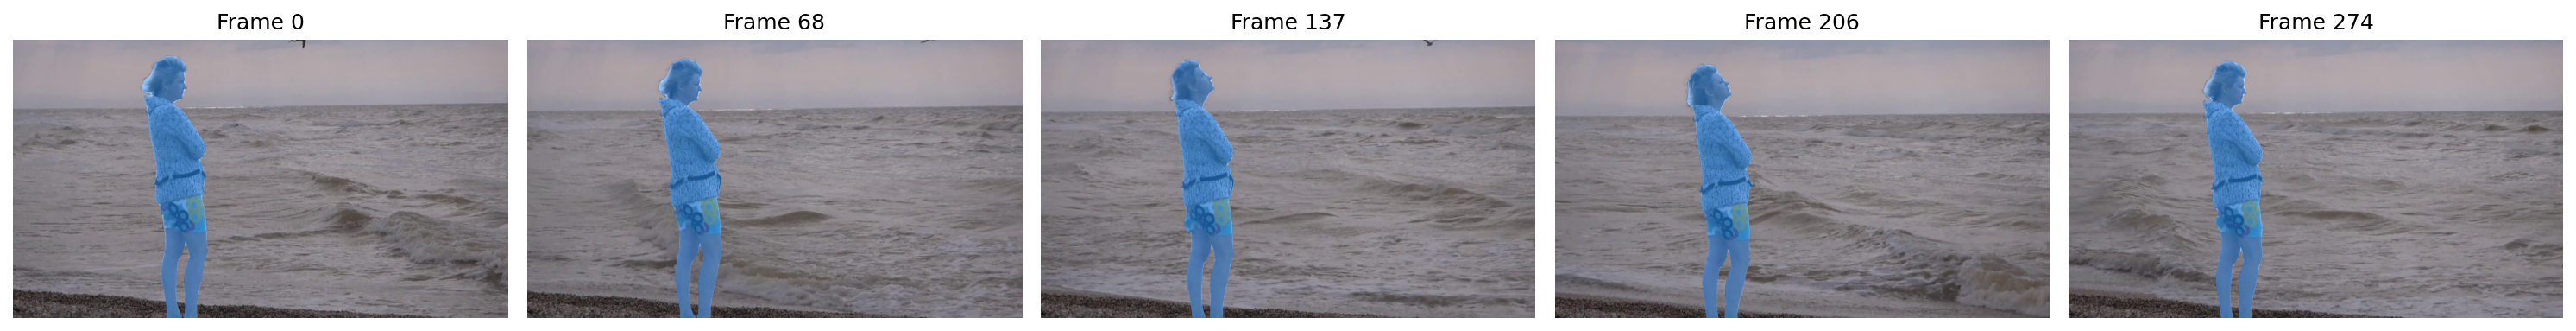

In [ ]:
img = Image.open('video_segmentation_samples.png')
img